# Part-2: MLP

Here we implement a multilayer perceptron (MLP) character-level language model using [Bengio et al. 2003 MLP language model paper.](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

### 1. Setting Up Environment and Loading the Dataset

In [1]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()# reading the file and splitting into list of
words[:8]# printing first 8 words

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)# number of words in the dataset

32033

In [4]:
#building the vocabulary of characters
chars = sorted(list(set(''.join(words))))# getting unique characters in the dataset and sorting them
stoi = {s:i+1 for i,s in enumerate(chars)}# mapping characters to integers (1-26)
stoi['.'] = 0# mapping the special character '.' to 0
itos = {i:s for s,i in stoi.items()}# mapping integers to characters
vocab_size = len(itos)# getting the vocabulary size
print('vocab size: ', vocab_size)
print(itos)

vocab size:  27
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


We need to create a mapping from characters to integers `(stoi)` and back `(itos)`. This allows us to represent our text data numerically, which is the only format a neural network can understand.<br>
Hence we create a sorted list of all unique characters and then add a special `.` token at index 0

- #### Building the Dataset

In [5]:
block_size = 3# context length: how many characters do we take to predict the next one
X, Y = [], []# input and output lists
for w in words:
    context = [0]*block_size# starting with a context of 3 '.' characters
    for ch in w + '.':# for each character in the word plus the special character
        ix = stoi[ch]# get the integer representation of the character
        X.append(context)# append the current context to the input list
        Y.append(ix)# append the integer representation of the character to the output list
        #print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix]# slide the context window to the right

X = torch.tensor(X)# converting input list to tensor
Y = torch.tensor(Y)# converting output list to tensor

Instead of just looking at the single previous character (a bigram) we will now use a **context** of multiple characters to predict the next one.
- `block_size = 3`: This is a crucial hyperparameter which defines our context length. Here block_size = 3 means our model will always use the last 3 characters to predict the 4th character.
- We iterate through each word and build our input `X` and target `Y` pairs.
    - For a name like "emma" the process is:
        1. `...` ---> `e` (context is [0, 0, 0], target is e)
        2. `..e` ---> `m` (context is [0, 0, e], target is m)
        3. `.em` ---> `m` (context is [0, e, m], target is m)
        4. `emm` ---> `a` (context is [e, m, a], target is a)
        5. `mma` ---> `.` (context is [m, m, a], target is .)

- `context = context[1:] + [ix]`: It is the "sliding window." After each prediction we slide the context.

> Finally X becomes a tensor where each row is a context of 3 character indices and Y is a tensor containing the corresponding target character index for each context.

In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [7]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        ...,
        [26, 26, 25],
        [26, 25, 26],
        [25, 26, 24]])

#### Creating Train, Validation and Test Splits

- `Training Set (Xtr, Ytr)`: The largest chunk (80% of the data). The model learns the patterns from this data.
- `Validation Set (Xdev, Ydev)`: A smaller portion (10%). We use this set to tune our model's hyperparameters (like embedding size, hidden layer size, learning rate) and to check for overfitting. The model does not train on this data.
- `Test Set (Xte, Yte)`: The final 10%. We use this set only once at the very end to get an unbiased evaluation of how well our final, tuned model performs on completely unseen data.

In [8]:
import random
def build_dataset(words):
  X, Y = [], []
  for w in words:

    # print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      # print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix]  # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y


random.seed(42)# setting the seed for reproducibility
random.shuffle(words)# shuffling the words
n1 = int(0.8*len(words))# first 80% for training
n2 = int(0.9*len(words))# next 10% for validation, last 10% for testing

Xtr, Ytr = build_dataset(words[:n1])# training set
Xdev, Ydev = build_dataset(words[n1:n2])# validation set
Xte, Yte = build_dataset(words[n2:])# test set

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


### 2. The Multi-Layer Perceptron (MLP) Model

#### The Embedding Layer

Instead of using large sparse one-hot vectors, we'll use **embeddings**.

- **What is it?** An embedding is a learned low-dimensional dense vector representation for each character in our vocabulary.
- `C = torch.randn((27, 2))`: This creates our embedding matrix, which acts as a lookup table. It has 27 rows (one for each character) and 2 columns. The 2 means we are choosing to represent each character with a 2-dimensional vector (i.e., a point in a 2D plane). This embedding dimension is a hyperparameter we can tune.

- **Benefit of using Embeddings:**
    - It's much smaller than a 27-dimensional one-hot vector.
    - The network will learn to place characters that are used in similar ways (like vowels or consonants) closer together in this 2D space therefore capturing semantic relationships that one-hot vectors cannot. 

In [9]:
C = torch.randn((27, 2))# the embedding matrix

Now we define how the embedding lookup works. `C[X]` uses the integer indices in X to retrieve the corresponding 2D embedding vectors from our matrix `C`.
- Input `X` shape: `(228146, 3)` (228,146 examples each with a 3-char context).
- Output `emb` shape: (228146, 3, 2) (For each of the 228,146 examples we now have the three 2D vectors corresponding to the three context characters with 2 being the size of the embedding vector for each character i.e. the embedding dimension).

In [10]:
emb = C[X]# embedding the input characters
emb.shape# shape of the embedded input

torch.Size([228146, 3, 2])

#### Building Hidden Layer
This is the first "neuron" layer of our MLP. It takes the embeddings as input and performs a non-linear transformation.
- `W1 = torch.randn((6, 100))`: The weight matrix for the hidden layer.
The input size is 6 because we have a 3-character context and each character is a 2D embedding (3 * 2 = 6). We will concatenate these embeddings to form a single 6D vector for each example.<br>
The output size is 100, meaning our hidden layer will have 100 neurons. This is another hyperparameter.
- `b1 = torch.randn(100)`: The bias vector for the 100 neurons in the hidden layer. Biases allow the neurons to shift their activation function, making them more flexible.

In [11]:
W1  = torch.randn((6,100))
b1 = torch.randn(100)

#### Hidden Layer Forward Pass
This block computes the output of the hidden layer:
- `emb.view(-1, 6)`: This is a crucial reshaping step. It takes our (228146, 3, 2) embedding tensor and transforms it into a (228146, 6) tensor. It does this by concatenating the three 2D vectors for each example into a single 6D vector. The -1 tells PyTorch to automatically infer the number of rows.<br>
The `.view()` function in PyTorch reshapes a tensor to have different dimensions while keeping the total number of elements the same.

```bash
For the context ' . e m '
[
  [-0.1565,  0.1425],  # Embedding for '.'
  [ 0.6479, -0.2573],  # Embedding for 'e'
  [-0.0123,  0.3681]   # Embedding for 'm'
]
```
When we apply .view(-1, 6), here's what each part does:
1. `The 6`: This is the desired number of columns for our new tensor. We get 6 because we want to combine the features of our 3 context characters and each character has a 2-dimensional embedding.

    - $3 (block_size) * 2 (embedding_dim) = 6$: This operation effectively takes the three 2D vectors and lays them end-to-end:
    $[-0.1565,  0.1425,   0.6479, -0.2573,   -0.0123,  0.3681]$

    - This new 6-dimensional vector is now a single, unified representation of the entire 3-character context.

2. The `-1`: This is a powerful placeholder. It tells PyTorch**I want the number of columns to be 6 and you should automatically figure out how many rows are needed to make it work.**<br>
PyTorch calculates this by taking the total number of elements in the tensor (32 * 3 * 2 = 192) and dividing by the specified number of columns (192 / 6 = 32). This ensures that our output tensor will have one row for each of the 32 examples in our minibatch.


- `@ W1 + b1`: We perform a matrix multiplication with the weights and add the bias. This is the standard linear operation of a neuron layer.

- `torch.tanh()`: We apply the hyperbolic tangent (tanh) activation function. Without a non-linear function between layers our multi-layer network would mathematically collapse into a single linear layer severely limiting its power. tanh squashes the output of each neuron to be between -1 and 1.

In [12]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)# hidden layer

In [13]:
h

tensor([[ 0.1250,  0.3907,  0.9784,  ..., -0.7286,  0.9744,  0.8753],
        [ 0.9905, -0.8181,  0.9932,  ...,  0.9322,  0.8646, -0.0396],
        [ 1.0000, -0.9996,  0.9977,  ...,  1.0000, -0.9910, -0.9971],
        ...,
        [ 0.9916, -1.0000,  0.9997,  ..., -0.3409,  0.9967,  0.9692],
        [-0.9690,  0.8625,  0.9999,  ..., -0.6991, -0.9808,  0.9971],
        [ 0.9992,  0.7552, -0.9954,  ..., -0.2669,  0.9743,  0.0947]])

In [14]:
h.shape

torch.Size([228146, 100])

#### The Output Layer
This is the final layer of our network. It takes the activations from the hidden layer and produces the final output.
- `W2 = torch.randn((100, 27))`: The weight matrix for the output layer.
    - The input size is 100 matching the number of neurons in our hidden layer.
    - The output size is 27 as we need one output number for each of the 27 possible next characters in our vocabulary.
- `b2 = torch.randn(27)`: The bias vector for the 27 output neurons.

In [15]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

#### Output Layer Forward Pass(Logits)
We perform the final matrix multiplication between the hidden layer activations `h` and the output weights `W2` and add the final bias `b2`. The result is our logits.<br>
**Logits** are the raw and unnormalized scores for each of the 27 characters. They can be thought of as log-counts similar to the output of our linear layer but they are now produced by a much more powerful non-linear model.

In [16]:
logits = h @ W2 + b2

In [17]:
logits.shape

torch.Size([228146, 27])

#### Converting Logits to Probabilities (Softmax)
To turn our logits into a valid probability distribution, we apply the softmax function. This is a two-step process:
- `counts = logits.exp()`: We exponentiate the logits. This makes all the numbers positive.
- `prob = counts / counts.sum(1, keepdims=True)`: We normalize each row so that all the values in that row sum to 1.0.

The prob tensor now contains for each input example the model's predicted probability for each of the 27 possible next characters.

In [18]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
prob.shape

torch.Size([228146, 27])

#### Calculating the Loss


In [19]:
loss = -prob[torch.arange(prob.shape[0]), Y].log().mean()
loss

tensor(20.2525)

### 3. Full Model and Training

In [20]:
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

#### Initializing All Model Parameters

In [21]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,10), generator=g)# character embeddings
W1 = torch.randn((30,200), generator=g)# first layer weights
b1 = torch.randn(200, generator=g)# first layer bias
W2 = torch.randn((200,27), generator=g)# second layer weights
b2 = torch.randn(27, generator=g)# second layer bias
parameters = [C, W1, b1, W2, b2]# list of all parameters

Here we initialize all the parameters of our network in one place. These are the numbers the model will learn during training.
- `C (Embedding Matrix)`: 27 characters each with a 10-dimensional embedding vector.
- `W1, b1 (Hidden Layer)`: 10 * 3 = 30 inputs, 200 hidden neurons.
- `W2, b2 (Output Layer)`: 200 inputs (from hidden layer) 27 outputs (for each character).
- `parameters`: We group all these tensors into a list for easier management during the training loop.

In [22]:
sum(p.nelement() for p in parameters)# number of parameters in total

11897

#### Enabling gradient tracking
We loop through all our parameters and set `requires_grad = True`. This tells PyTorch to track the computational graph for these tensors so it can automatically compute gradients during the backward pass.

In [23]:
for p in parameters:
    p.requires_grad = True# enabling gradient tracking

#### Setting Up Learning Rates
Here we create a range of learning rates logarithmically spaced from $10^{-3} (0.001)$ to $10^{0} (1.0)$.

- `lre = torch.linspace(-3, 0, 1000)`: This line creates a tensor named lre (learning rate exponent) containing 1000 evenly spaced numbers between -3 and 0.
- `lrs = 10**lre`: This line takes 10 to the power of each exponent in the lre tensor. This transforms the linear scale of exponents (-3, -2.99, ... 0) into a logarithmic scale of actual learning rates (10⁻³, ..., 10⁰), which is 0.001 to 1.0.

In [24]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [25]:
lri = []# learning rate index
lossi = []# loss values
stepi = []# step index

#### The Full Training Loop

In [ ]:
for i in range(200000):
    #construct the minibatch for each iteration
    ix = torch.randint(0, Xtr.shape[0], (32,))# random minibatch of 32 samples
    
    # forward pass
    emb = C[Xtr[ix]]# embed the characters into vectors (32, 3, 10)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)# hidden layer (32, 200)
    logits = h @ W2 + b2# output layer (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])# cross-entropy loss
    
    #backward pass
    for p in parameters:
        p.grad = None# setting the gradients to zero
    loss.backward()# backpropagation
    
    #update the parameters
    #lr = lrs[i]# learning rate
    lr = 0.1 if i < 100000 else 0.01# using a fixed learning rate schedule
    for p in parameters:
        p.data += -lr * p.grad# gradient descent step
    
    #lri.append(lre[i].item())# appending the learning rate index
    stepi.append(i)# appending the step index
    lossi.append(loss.log10().item())# appending the loss value

print(loss.item())# printing the final loss value

2.4106597900390625


This is where we train our MLP using gradient descent.
- **Looping:** We run the optimization for 200,000 steps.
- **Minibatch Construction:** In each step we don't use the entire dataset. Instead we randomly select a small minibatch of 32 examples (`ix = torch.randint(...)`). This is a standard technique called Stochastic Gradient Descent (SGD).
- **Forward Pass:**
    1. `emb = C[Xtr[ix]]`: Get the embeddings for the 32 examples in our minibatch.
    2. `h = torch.tanh(...)`: Compute the hidden layer activations.
    3. `logits = h @ W2 + b2`: Compute the final logits.
    4. `loss = F.cross_entropy(logits, Ytr[ix])`: Calculate the cross-entropy loss for this minibatch. This function is a highly optimized combination of the softmax and negative log likelihood steps.

- **Backward Pass:**
    1. `p.grad = None`: Reset all gradients to zero.
    2. `loss.backward()`: Compute the gradients of the loss with respect to all parameters.

- **Update:**
    1. `lr = 0.1 if i < 100000 else 0.01`: This is our learning rate schedule. We use a larger learning rate (0.1) for the first half of training to make big progress and then "decay" it to a smaller rate (0.01) for the second half to fine-tune the weights more carefully.
    2. `p.data += -lr * p.grad`: Update each parameter using its gradient.

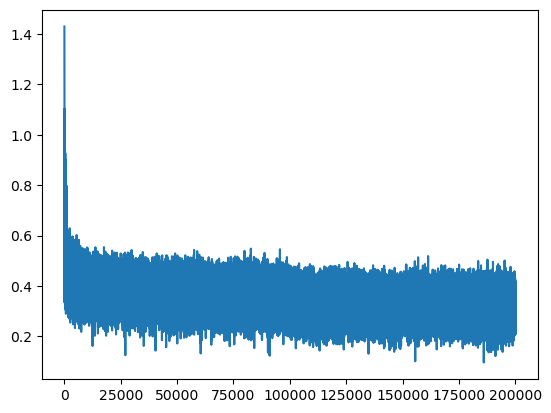

In [30]:
plt.plot(stepi, lossi)

This shows that our model learned quickly at the beginning and then converged to a good solution. The small bump at 100,000 steps is where we decreased the learning rate causing a temporary instability before the model settled into a new phase of fine-tuning.

#### Evaluating the Training Loss
After training is complete we run a final forward pass on the entire training set (`Xtr`) to get the final training loss. This tells us how well the model fits the data it was trained on.

In [33]:
emb = C[Xtr]  # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)  # (32, 100)
logits = h @ W2 + b2  # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1293, grad_fn=<NllLossBackward0>)

#### Evaluating the Validation Loss

In [34]:
emb = C[Xdev]# (32, 3, 2) 
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)# (32, 100)
logits = h @ W2 + b2# (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1667, grad_fn=<NllLossBackward0>)

### 4. Visualising and Sampling

#### Visualizing the Character Embeddings
Following plot visualizes the 10-dimensional character embeddings we've learned by plotting the first two dimensions.


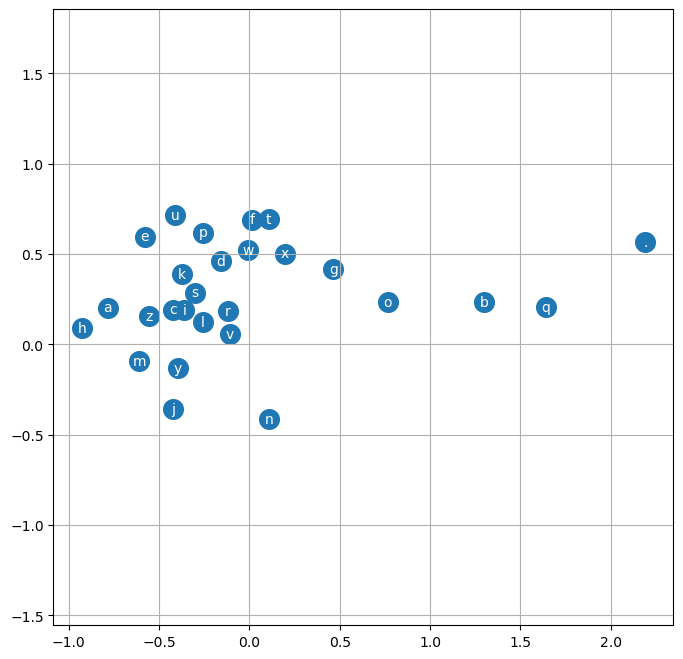

In [37]:
plt.figure(figsize = (8,8))# creating a figure of size 8x8
plt.scatter(C[:,0].data, C[:,1].data, s = 200)# scatter plot of the first two dimensions of the character embeddings with size 200
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha = 'center', va = 'center', color = 'white')# adding text labels to the points
plt.grid('minor')# adding minor grid lines
plt.axis('equal')# setting equal scaling for both axes
plt.show()